# Fuga de Clientes

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

## Inicialización

In [126]:
# Importar librerías
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

## Carga de datos

In [3]:
# Importar datastes
contracts = pd.read_csv("./files/datasets/input/contract.csv")
internet = pd.read_csv("./files/datasets/input/internet.csv")
personal = pd.read_csv("./files/datasets/input/personal.csv")
phone = pd.read_csv("./files/datasets/input/phone.csv")

## Análisis exploratorio

### contract

In [4]:
# Imprimir datos
contracts

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0                 Yes           Electronic check           29.85        29.85  
1                  No               Mailed check           56.95       1889.5  
2                 Yes               Mailed check           53.85       108.15  
3                  No  Bank transfer (automatic)           42.30      1840.75  
4                 Yes           Electronic check           70.70       151.65  
...               ...                        ...             ...          ...  
7038              Yes               Mailed check           84.80       1990.5  
7039              Yes    Credit card (automatic)          103.20       7362.9  
7040              Yes           Electronic check           29.60       346.45  
7041              Yes               Mailed check           74.40        306.6  
7042              Yes  Bank transfer (automatic)          105.65       6844.5  

[7043 rows x 8 columns]

In [5]:
# Ver información del dataset
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
# Verificar número de cliente únicos
contracts['customerID'].nunique()

7043

In [7]:
# Verificar contenido en 'TotalCharges'
contracts['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

In [8]:
# Ver casos con valores nulos
contracts.query("TotalCharges==' '")

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

In [9]:
# Filtrar contratos sin cobos totales
contract_with_charges = contracts.query("TotalCharges not in' '")
contract_with_charges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   object 
dtypes: float64(1), object(7)
memory usage: 494.4+ KB


In [10]:
# Ver información estadísica de varaible numéricas
contract_with_charges['TotalCharges'] = contract_with_charges['TotalCharges'].astype(float)
contract_with_charges.describe()

C:\Users\ricar\AppData\Local\Temp\ipykernel_27344\1058132662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_with_charges['TotalCharges'] = contract_with_charges['TotalCharges'].astype(float)


MonthlyCharges  TotalCharges
count     7032.000000   7032.000000
mean        64.798208   2283.300441
std         30.085974   2266.771362
min         18.250000     18.800000
25%         35.587500    401.450000
50%         70.350000   1397.475000
75%         89.862500   3794.737500
max        118.750000   8684.800000

### internet

In [11]:
# Ver sample de data
internet.sample(10)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
1190  4472-VESGY     Fiber optic            Yes          Yes              Yes   
5023  6608-QQLVK             DSL             No           No              Yes   
4734  0401-WDBXM     Fiber optic            Yes           No              Yes   
1990  0022-TCJCI             DSL            Yes           No              Yes   
1224  3794-NFNCH             DSL             No           No              Yes   
637   5173-WXOQV             DSL             No          Yes               No   
3711  1582-RAFML             DSL             No          Yes               No   
566   7133-VBDCG     Fiber optic            Yes          Yes               No   
1068  1371-DWPAZ             DSL            Yes          Yes              Yes   
4030  8062-YBDOE     Fiber optic             No           No               No   

     TechSupport StreamingTV StreamingMovies  
1190          No          No             Yes  
5023          No          No              No  
4734          No         Yes             Yes  
1990          No          No             Yes  
1224          No          No              No  
637          Yes          No             Yes  
3711         Yes          No              No  
566           No          No              No  
1068         Yes         Yes              No  
4030          No          No              No

In [12]:
# Ver clientes únicos
internet['customerID'].nunique()

5517

In [13]:
# Ver info de data
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### personal

In [14]:
# Ver sample de data
personal.sample(10)

customerID  gender  SeniorCitizen Partner Dependents
4701  5956-YHHRX    Male              1      No         No
3142  4892-VLANZ    Male              0      No         No
5751  0932-YIXYU  Female              0      No         No
6513  1794-SWWKL    Male              0     Yes        Yes
5606  6586-PSJOX    Male              0      No        Yes
1341  9269-CQOOL    Male              0      No        Yes
5727  8707-HOEDG  Female              0     Yes        Yes
1584  9906-NHHVC  Female              1      No         No
4602  1240-HCBOH  Female              0      No         No
298   2985-JUUBZ    Male              0     Yes        Yes

In [15]:
# Ver info de data
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### phone

In [16]:
# Ver sample de data
phone.sample(10)

customerID MultipleLines
5681  0885-HMGPY           Yes
3137  5397-TUPSH            No
1838  5155-AZQPB           Yes
5441  3462-BJQQA           Yes
2400  0880-FVFWF           Yes
3199  0748-RDGGM            No
5532  8573-CGOCC            No
4717  7245-JMTTQ           Yes
4074  3714-JTVOV            No
3012  3866-MDTUB            No

In [17]:
# Ver info de data
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [18]:
# Verificar si hay clinetes con ambos servicios
phone.merge(internet, how='left')

customerID MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     5575-GNVDE            No             DSL            Yes           No   
1     3668-QPYBK            No             DSL            Yes          Yes   
2     9237-HQITU            No     Fiber optic             No           No   
3     9305-CDSKC           Yes     Fiber optic             No           No   
4     1452-KIOVK           Yes     Fiber optic             No          Yes   
...          ...           ...             ...            ...          ...   
6356  2569-WGERO            No             NaN            NaN          NaN   
6357  6840-RESVB           Yes             DSL            Yes           No   
6358  2234-XADUH           Yes     Fiber optic             No          Yes   
6359  8361-LTMKD           Yes     Fiber optic             No           No   
6360  3186-AJIEK            No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies  
0                 Yes          No          No              No  
1                  No          No          No              No  
2                  No          No          No              No  
3                 Yes          No         Yes             Yes  
4                  No          No         Yes              No  
...               ...         ...         ...             ...  
6356              NaN         NaN         NaN             NaN  
6357              Yes         Yes         Yes             Yes  
6358              Yes          No         Yes             Yes  
6359               No          No          No              No  
6360              Yes         Yes         Yes             Yes  

[6361 rows x 9 columns]

### Pre-preparación de datos

In [19]:
# Unir data frames
df = contracts.merge(phone, how='left')
df = df.merge(internet, how='left')
df = df.merge(personal, how='left')
df

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check           29.85        29.85   
1                  No               Mailed check           56.95       1889.5   
2                 Yes               Mailed check           53.85       108.15   
3                  No  Bank transfer (automatic)           42.30      1840.75   
4                 Yes           Electronic check           70.70       151.65   
...               ...                        ...             ...          ...   
7038              Yes               Mailed check           84.80       1990.5   
7039              Yes    Credit card (automatic)          103.20       7362.9   
7040              Yes           Electronic check           29.60       346.45   
7041              Yes               Mailed check           74.40        306.6   
7042              Yes  Bank transfer (automatic)          105.65       6844.5   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0              NaN             DSL             No          Yes   
1               No             DSL            Yes           No   
2               No             DSL            Yes          Yes   
3              NaN             DSL            Yes           No   
4               No     Fiber optic             No           No   
...            ...             ...            ...          ...   
7038           Yes             DSL            Yes           No   
7039           Yes     Fiber optic             No          Yes   
7040           NaN             DSL            Yes           No   
7041           Yes     Fiber optic             No           No   
7042            No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies  gender  \
0                  No          No          No              No  Female   
1                 Yes          No          No              No    Male   
2                  No          No          No              No    Male   
3                 Yes         Yes          No              No    Male   
4                  No          No          No              No  Female   
...               ...         ...         ...             ...     ...   
7038              Yes         Yes         Yes             Yes    Male   
7039              Yes          No         Yes             Yes  Female   
7040               No          No          No              No  Female   
7041               No          No          No              No    Male   
7042              Yes         Yes         Yes             Yes    Male   

      SeniorCitizen Partner Dependents  
0                 0     Yes         No  
1                 0      No         No  
2                 0      No         No  
3                 0      No         No  
4                 0      No         No  
...             ...     ...        ...  
7038              0     Yes        Yes  
7039              0     Yes        Yes  
7040              0     Yes        Yes  
7041              1     Yes         No  
7042              0      No         No  

[7043 rows x 20 columns]

In [20]:
# Verificar información del dataframe final
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   MultipleLines     6361 non-null   object 
 9   InternetService   5517 non-null   object 
 10  OnlineSecurity    5517 non-null   object 
 11  OnlineBackup      5517 non-null   object 
 12  DeviceProtection  5517 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  StreamingTV       5517 non-null   object 
 15  StreamingMovies   5517 non-null   object 
 16  gender            7043 non-null   object 


Al unir los datasets, las columnas respectivas a los ervicios (phone y internet), contienen valores nulos debido a que hay clientes que sol tiene uno de estos servicios. Reemplazaremos estos valores nulo con la palabra "non-contracted" para identificar estos casos.

In [21]:
# Reemplazar valores nulos
df.fillna("non-contracted", inplace=True)
df

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check           29.85        29.85   
1                  No               Mailed check           56.95       1889.5   
2                 Yes               Mailed check           53.85       108.15   
3                  No  Bank transfer (automatic)           42.30      1840.75   
4                 Yes           Electronic check           70.70       151.65   
...               ...                        ...             ...          ...   
7038              Yes               Mailed check           84.80       1990.5   
7039              Yes    Credit card (automatic)          103.20       7362.9   
7040              Yes           Electronic check           29.60       346.45   
7041              Yes               Mailed check           74.40        306.6   
7042              Yes  Bank transfer (automatic)          105.65       6844.5   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     non-contracted             DSL             No          Yes   
1                 No             DSL            Yes           No   
2                 No             DSL            Yes          Yes   
3     non-contracted             DSL            Yes           No   
4                 No     Fiber optic             No           No   
...              ...             ...            ...          ...   
7038             Yes             DSL            Yes           No   
7039             Yes     Fiber optic             No          Yes   
7040  non-contracted             DSL            Yes           No   
7041             Yes     Fiber optic             No           No   
7042              No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies  gender  \
0                  No          No          No              No  Female   
1                 Yes          No          No              No    Male   
2                  No          No          No              No    Male   
3                 Yes         Yes          No              No    Male   
4                  No          No          No              No  Female   
...               ...         ...         ...             ...     ...   
7038              Yes         Yes         Yes             Yes    Male   
7039              Yes          No         Yes             Yes  Female   
7040               No          No          No              No  Female   
7041               No          No          No              No    Male   
7042              Yes         Yes         Yes             Yes    Male   

      SeniorCitizen Partner Dependents  
0                 0     Yes         No  
1                 0      No         No  
2                 0      No         No  
3                 0      No         No  
4                 0      No         No  
...             ...     ...        ...  
7038              0     Yes        Yes  
7039              0     Yes        Yes  
7040              0     Yes        Yes  
7041              1     Yes         No  
7042              0      No         No  

[7043 rows x 20 c

Ahora cambiaremos los nombres de la columnas usando un función que aplica el método "snake"

In [22]:
# Crear función para cambiar nombres de columnas
def to_snake_case(name):
    name = name.replace(' ', '_')
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Renombrar columnas usando la función to_snake_case
df.columns = [to_snake_case(col) for col in df.columns]

In [23]:
# Verificar cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   multiple_lines     7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  gender             7043 

Ahora en el acaso de la columna "total_charges", el cual contiene registros sin valores numéricos (" "), serán filtrados debido a que forman menos del 1% del dataset. Estos casos se deben a que todabía no se ha cumplido el periodo del contrato de paga.

In [24]:
# Filtrar los registros donde la columna 'B' contiene un espacio en blanco
df = df[df['total_charges'] != ' ']
df['total_charges'] = df['total_charges'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   multiple_lines     7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  gender             7032 non-n

C:\Users\ricar\AppData\Local\Temp\ipykernel_27344\2532980684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_charges'] = df['total_charges'].astype(float)


In [25]:
# Agregar columna churn
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

C:\Users\ricar\AppData\Local\Temp\ipykernel_27344\1324548742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)


In [26]:
df.head()

customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges  \
0               Yes           Electronic check            29.85   
1                No               Mailed check            56.95   
2               Yes               Mailed check            53.85   
3                No  Bank transfer (automatic)            42.30   
4               Yes           Electronic check            70.70   

   total_charges  multiple_lines internet_service  ... online_backup  \
0          29.85  non-contracted              DSL  ...           Yes   
1        1889.50              No              DSL  ...            No   
2         108.15              No              DSL  ...           Yes   
3        1840.75  non-contracted              DSL  ...            No   
4         151.65              No      Fiber optic  ...            No   

  device_protection tech_support streaming_tv streaming_movies  gender  \
0                No           No           No               No  Female   
1               Yes           No           No               No    Male   
2                No           No           No               No    Male   
3               Yes          Yes           No               No    Male   
4                No           No           No               No  Female   

  senior_citizen  partner dependents churn  
0              0      Yes         No     0  
1              0       No         No     0  
2              0       No         No     1  
3              0       No         No     0  
4              0       No         No     1  

[5 rows x 21 columns]

## Análisis de datos

Ahora que tenemos nuestro dataset pre-procesado, comenzaremos a analizar las variables a través de gráficos de histogramas y boxplots, separaremos nuestro análisis en varaibles numéricas y categóricas. También veremos la evolución de los contratos de los servicios.

In [27]:
# Estableceer columna numéricas y categóricas
numeric_columns = ['monthly_charges' ,'total_charges']
categorical_columns = list(set(df.columns) - set(numeric_columns) - set(['customer_id', 'begin_date', 'end_date']))

### Análisis variables numéricas

monthly_charges:
Median: 70.35
Mean: 70.35

total_charges:
Median: 1397.475
Mean: 1397.475



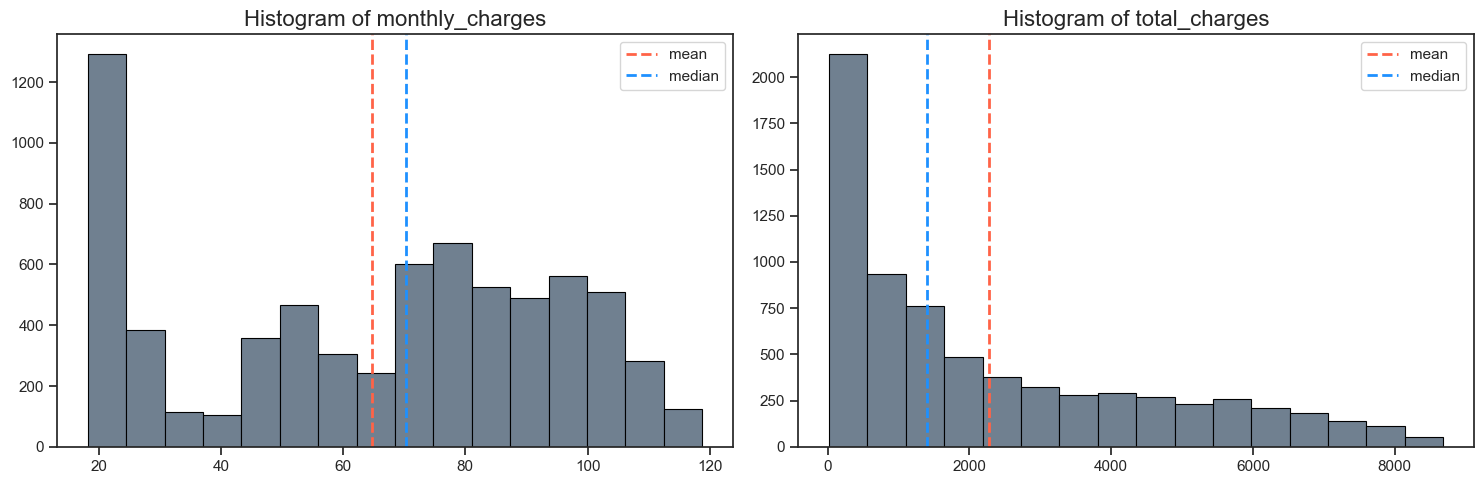

In [28]:
# Graficar histogramas por columna
sns.set(style="ticks")

num_vars = len(numeric_columns)
num_rows = num_vars // 2
num_rows += num_vars % 2 

# Crear sub gráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5)) 

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna numérica y crear histograma
for i, col in enumerate(numeric_columns):
    axes[i].hist(df[col], bins=16, color='slategray', edgecolor="black", linewidth=0.8)
    
    # Dibujar líneas para media y mediana
    mean_val = df[col].mean()
    median_val = df[col].median()
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

    print(f'{col}:')
    print(f'Median: {median_val}')
    print(f'Mean: {median_val}')
    print()
    
    # Anadir leyenda
    axes[i].legend([mean_line, median_line], ['mean', 'median'])
    axes[i].set_title(f'Histogram of {col}', fontsize=16)
    
# Remover sub gráficos no usados
if len(numeric_columns) % 2:
    for j in range(i+1, num_rows*2):
        fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

monthly_charges:
Median: 70.35
Mean: 64.79820819112628

total_charges:
Median: 1397.475
Mean: 2283.300440841866



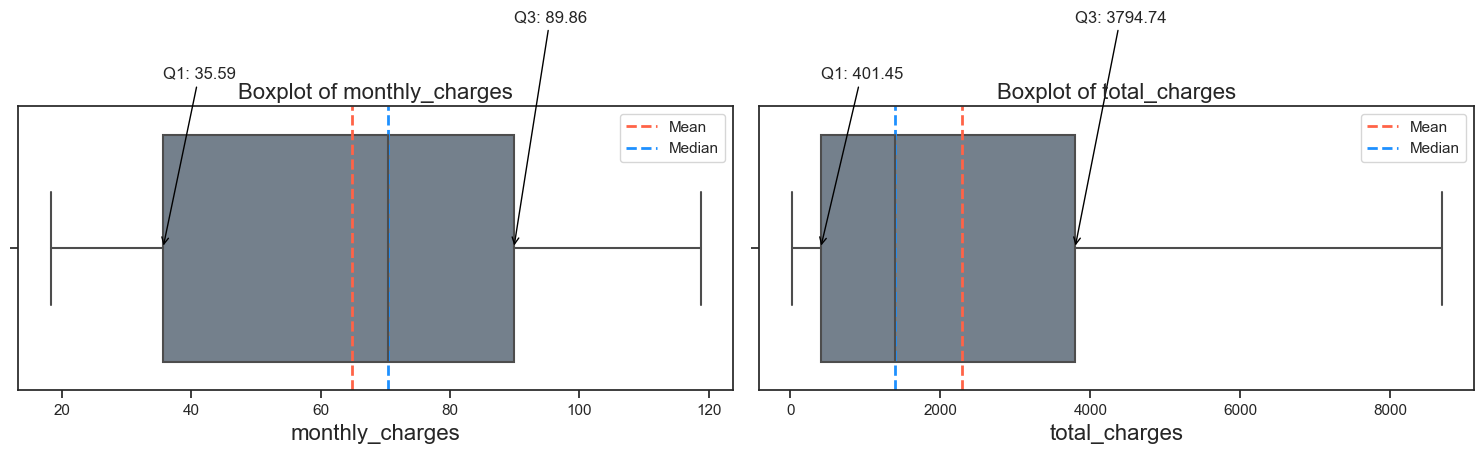

In [29]:
# Graficar boxplots por columna
sns.set(style="ticks")

num_vars = len(numeric_columns)
num_rows = num_vars // 2
num_rows += num_vars % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], color='slategray', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=20, weight='bold')
    axes[i].set_xlabel(col, fontsize=16)
    
    mean_val = df[col].mean()
    median_val = df[col].median()
    q1_val = df[col].quantile(0.25)
    q3_val = df[col].quantile(0.75)
    
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)
    
    # Annotate the lines
    axes[i].annotate(f'Q1: {q1_val:.2f}', xy=(q1_val, 0), xytext=(q1_val, -0.6),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'), fontsize=12)
    axes[i].annotate(f'Q3: {q3_val:.2f}', xy=(q3_val, 0), xytext=(q3_val, -0.8),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'), fontsize=12)
    
    print(f'{col}:')
    print(f'Median: {median_val}')
    print(f'Mean: {mean_val}')
    print()
    
    axes[i].legend([mean_line, median_line], ['Mean', 'Median'])
    axes[i].set_title(f'Boxplot of {col}', fontsize=16)

plt.tight_layout()
plt.show()

Analizando nuestros histogramas, podemos extraer las siguientes primeras conlusiones importantes:

- **monthly_charges**: muestra un sesgo hacia la izquierda, donde la mayoría de las cargas mensuales se concentran entre los $35 y $90 aproximadamente. No se muestran valores atípicos.


- **total_charges**: muestra un sesgo hacia la derecha, donde la mayoría de las cargas totales se concentran entre los $400 y $3,800 aproximadamente. No se muestran valores atípicos.

Como hemos podido verificar, tanto los cargos mensuales como totales muestran sesgos en su distribución. Sin embargo, no parecen mostrar valores atípicos que deban preocuparnos.

### Análisis variables categóricas

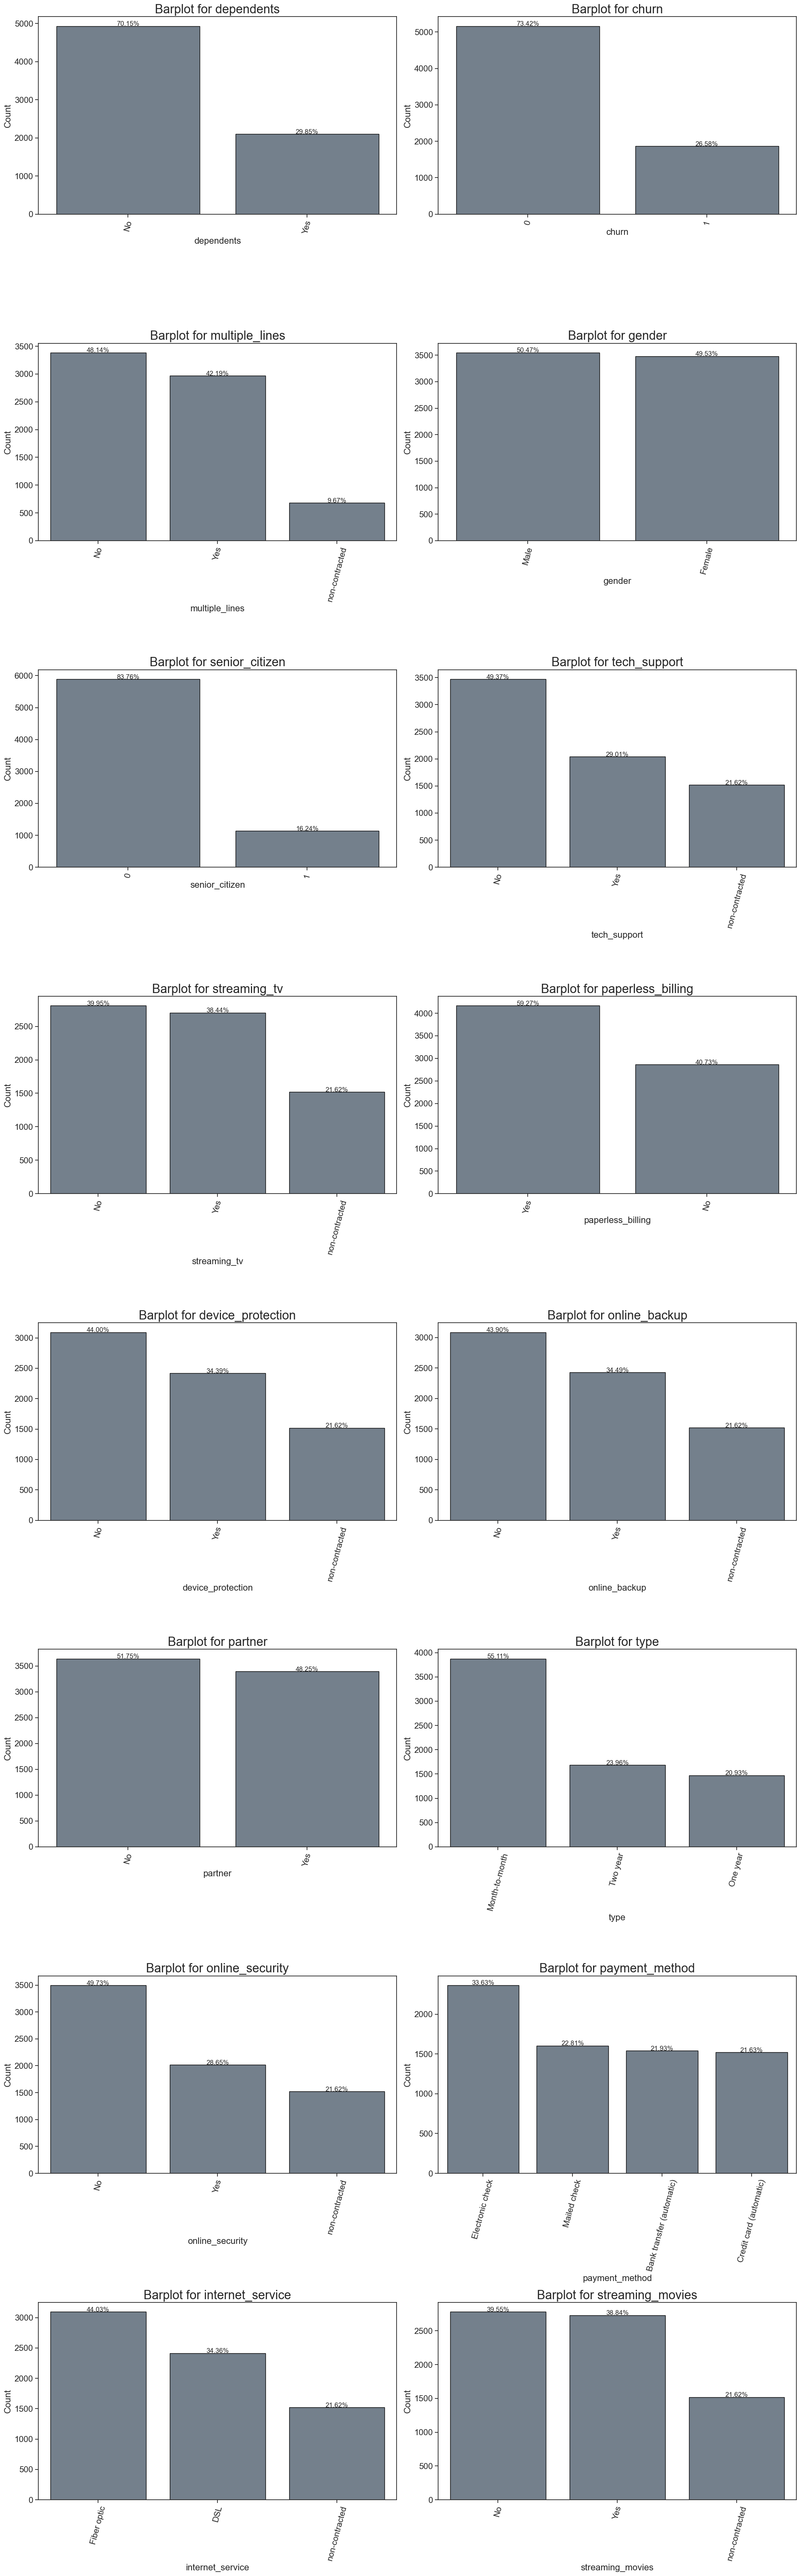

In [30]:
# Establecer el estilo de seaborn
sns.set(style="ticks")

# Determinar el número de filas necesarias para nuestros subgráficos
num_vars = len(categorical_columns)
num_rows = num_vars // 2
num_rows += num_vars % 2

# Crear los subgráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows*8))

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna
for i, column in enumerate(categorical_columns):
    total = len(df[column])  # Total number of data points for each column
    column_order = df[column].value_counts().nlargest(15).index
    ax = sns.countplot(x=column, data=df, order=column_order, ax=axes[i], color="slategray", edgecolor='black')

    for p in ax.patches:
        height = p.get_height()  # Get the height of the bar
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}'.format((height / total) * 100) + '%',  # Calculate and format percentage
                ha="center",
                fontsize=12)

    axes[i].set_title(f'Barplot for {column}', fontsize=22)
    axes[i].set_xlabel(column, fontsize=16)
    axes[i].set_ylabel('Count', fontsize=16)
    axes[i].tick_params(axis='x', rotation=75, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

En el caso de las columnas categóricas, podemos concluir lo siguiente:

- **churn**: el 26.54% de clientes han dado de baja el servico frente a los 74.46% que siguen siendo clientes.

- **type**: el tipo de plan más popular es "month-to-month" (+50%), "two-year" (24.07%) y "one-year" (20.91%) siguen respectivamente con poca diferencia entre ellos.

- **payment_method**: La opción más popular de medio de pago es cheque eléctrónico (33.58%), lo demás medios de pago presentan una concentración similar de clientes (20% aproximadamente) donde la tarjeta de crédito es el medio de pago menos usado (21.61%).

- **paperless_billing**: la mayoría de contratos son de cargos sin uso de papel (59.22%).

- **gender**: la distribución entre clientes hombres y muejeres es casi igual, los hombres son ligeremente superior en cantidad.

- **dependents**: la mayoría de los clientes no tienen dependendientes (70.04%).

- **partner**: la distribución entre cliente con parejas (48.30%) y sin parajes es muy similar (51.70%), los que no tienen parejas son de mayor cantidad.

- **senior_citizen**: la gran parte de los clientes no son seniors (83.79%), es decir personas de la tercera edad (16.21%).

- **multiple_lines**: la mayoría de clientes que tiene el servicio de telefonía fija no son de múltiples líneas (48.13%) comparado con lo que si (42.18%).

- **streaming_tv**: la cantida de personas que adquiere y no adquiere el servicio de streming es muy similar, 38.44% vs 39.90%.

- **online_backup**: la mayoría de clientes no contratan el servicio de soporte online (43.84%) frente a lo que si (34.49%).

- **tech_support**: al igual que el soporte online, el soporte técnico tampoco es tan adquirido (49.31%), incluso es menos adquirido que el online.

- **internet_service**: la fibra óptica es el tipo de servicio de internte más contratado (43.96%), frente a los de DSL (34.37%).

- **device_protection**: este servicio tampoco es mu popular entre los clientes (43.94%).

- **online_security**: la mayoría de clinetes no contrata el servicio de seguridad online (49.67%).

- **streaming_movies**: la proporción entre los que no contratn y contratan el servidcio de streming de películas es casi igual (39.54% vs 21.67%).


Por último, veremos la relación que presentan las variables a través de un scatterplot y una matriz de correlación.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   multiple_lines     7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  gender             7032 non-n

In [32]:
df.drop(['customer_id'], axis=1)

begin_date             end_date            type paperless_billing  \
0     2020-01-01                   No  Month-to-month               Yes   
1     2017-04-01                   No        One year                No   
2     2019-10-01  2019-12-01 00:00:00  Month-to-month               Yes   
3     2016-05-01                   No        One year                No   
4     2019-09-01  2019-11-01 00:00:00  Month-to-month               Yes   
...          ...                  ...             ...               ...   
7038  2018-02-01                   No        One year               Yes   
7039  2014-02-01                   No        One year               Yes   
7040  2019-03-01                   No  Month-to-month               Yes   
7041  2019-07-01  2019-11-01 00:00:00  Month-to-month               Yes   
7042  2014-08-01                   No        Two year               Yes   

                 payment_method  monthly_charges  total_charges  \
0              Electronic check            29.85          29.85   
1                  Mailed check            56.95        1889.50   
2                  Mailed check            53.85         108.15   
3     Bank transfer (automatic)            42.30        1840.75   
4              Electronic check            70.70         151.65   
...                         ...              ...            ...   
7038               Mailed check            84.80        1990.50   
7039    Credit card (automatic)           103.20        7362.90   
7040           Electronic check            29.60         346.45   
7041               Mailed check            74.40         306.60   
7042  Bank transfer (automatic)           105.65        6844.50   

      multiple_lines internet_service online_security online_backup  \
0     non-contracted              DSL              No           Yes   
1                 No              DSL             Yes            No   
2                 No              DSL             Yes           Yes   
3     non-contracted              DSL             Yes            No   
4                 No      Fiber optic              No            No   
...              ...              ...             ...           ...   
7038             Yes              DSL             Yes            No   
7039             Yes      Fiber optic              No           Yes   
7040  non-contracted              DSL             Yes            No   
7041             Yes      Fiber optic              No            No   
7042              No      Fiber optic             Yes            No   

     device_protection tech_support streaming_tv streaming_movies  gender  \
0                   No           No           No               No  Female   
1                  Yes           No           No               No    Male   
2                   No           No           No               No    Male   
3                  Yes          Yes           No               No    Male   
4                   No           No           No               No  Female   
...                ...          ...          ...              ...     ...   
7038               Yes          Yes          Yes              Yes    Male   
7039               Yes           No          Yes              Yes  Female   
7040                No           No           No               No  Female   
7041                No           No           No               No    Male   
7042               Yes          Yes          Yes              Yes    Male   

      senior_citizen partner dependents  churn  
0                  0     Yes         No      0  
1                  0      No         No      0  
2                  0      No         No      1  
3                  0      No         No      0  
4                  0      No         No      1  
...              ...     ...        ...    ...  
7038               0     Yes        Yes      0  
7039               0     Yes        Yes      0  
7040               0     Yes        Yes      0  
7041               1     Yes    

c:\Users\ricar\Escritorio\GitHub\final_project\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


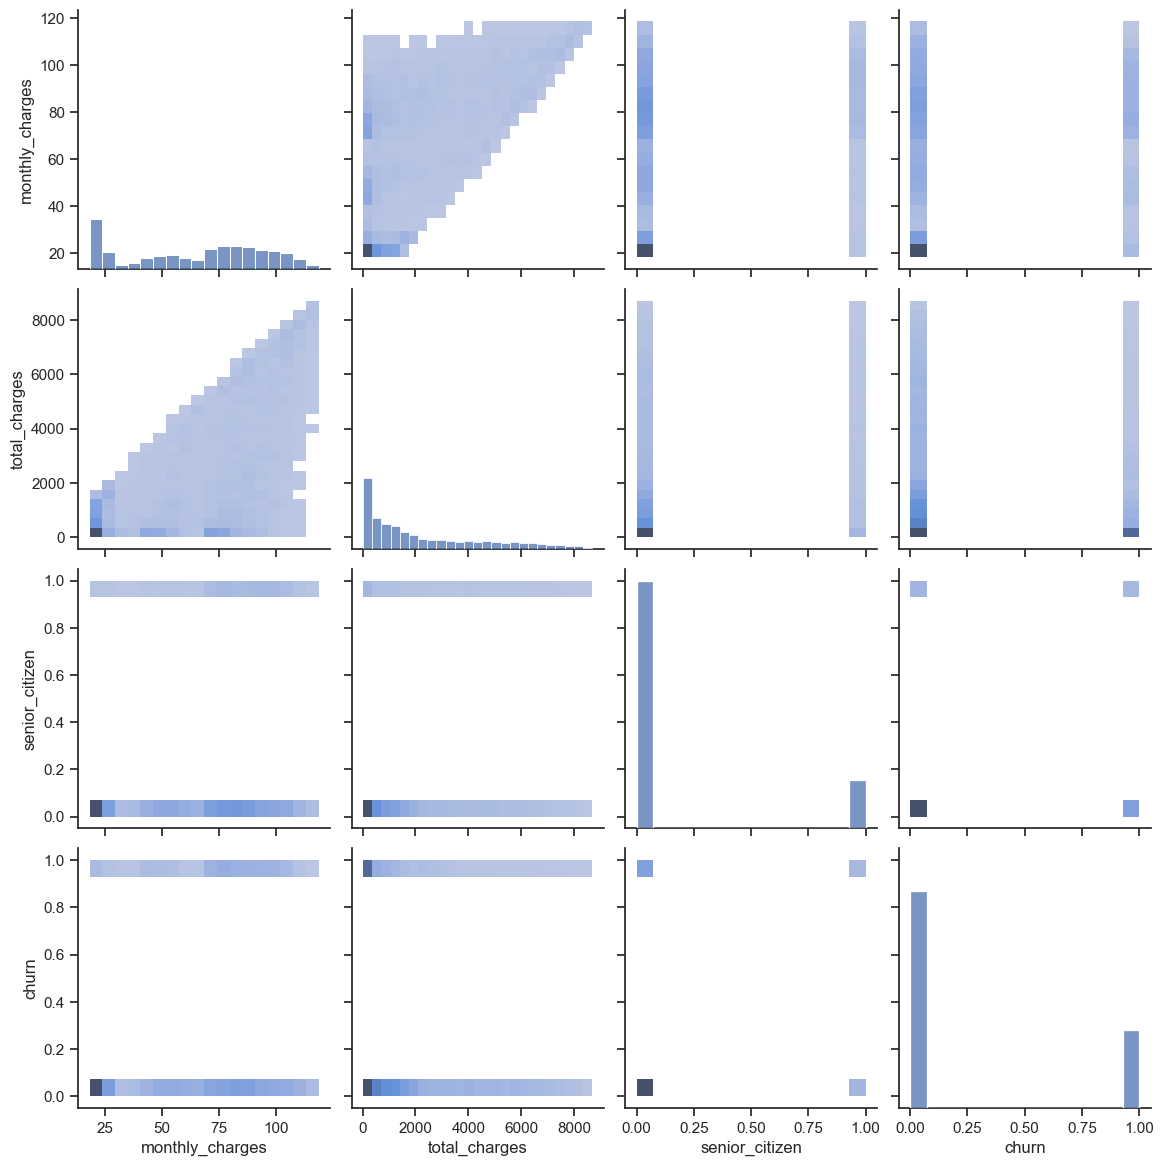

In [33]:
# Graficar gráfico de pares
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

c:\Users\ricar\Escritorio\GitHub\final_project\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


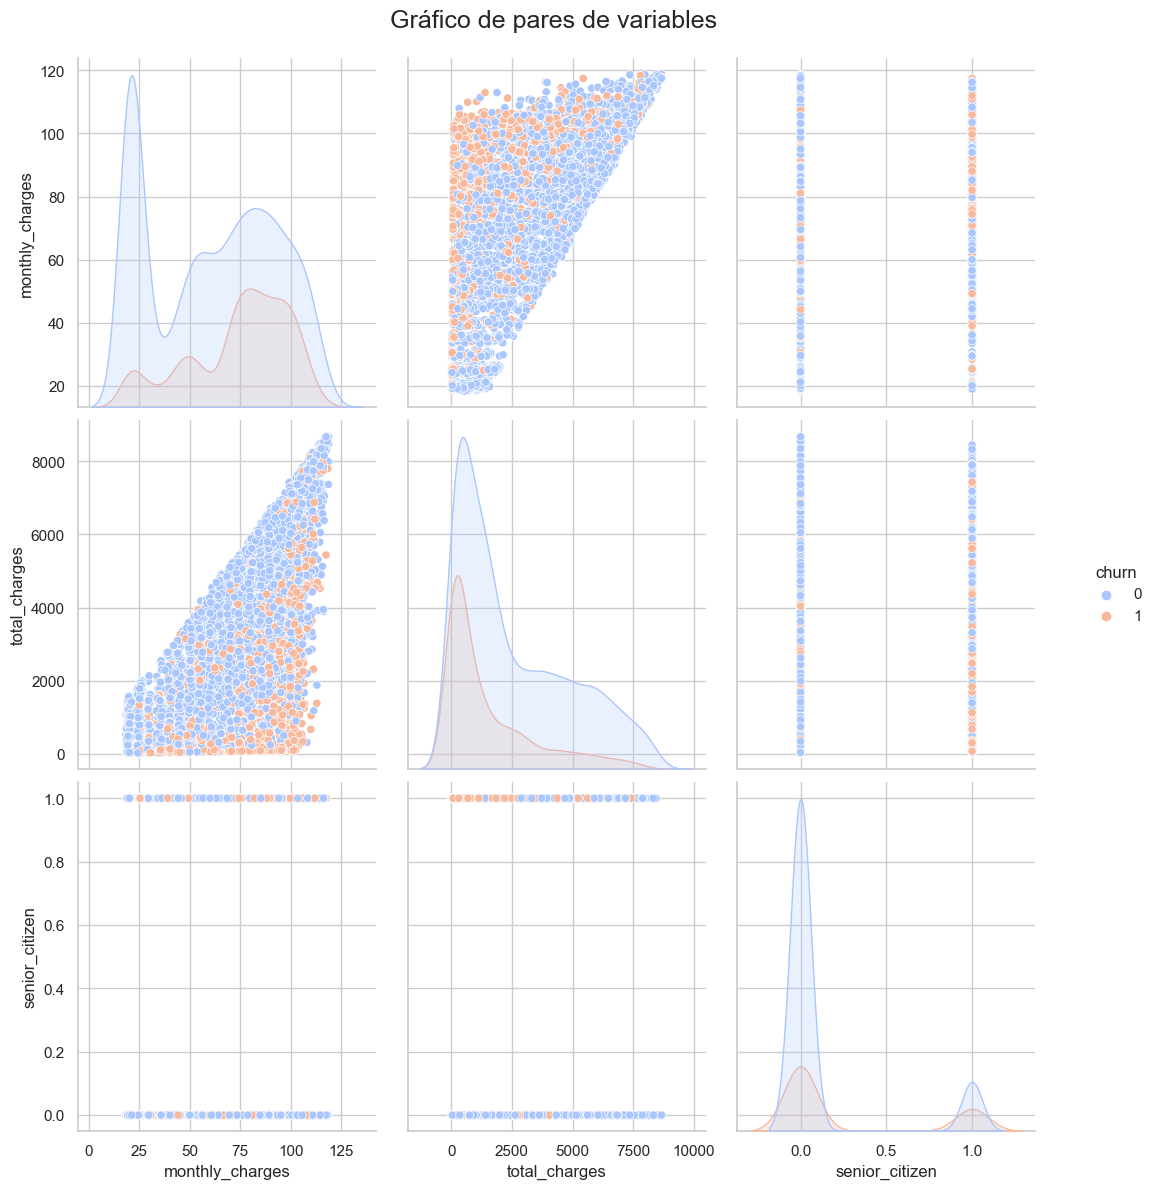

In [34]:
# Establecer el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico de pares
g = sns.pairplot(df, kind='scatter', diag_kind='kde',
                 hue='churn', # Cambia 'alguna_columna_categorica' por una columna categórica real de tu df si la tienes
                 palette='coolwarm')

# Establecer el tamaño del gráfico
g.fig.set_size_inches(12, 12)

# Agregar un título general
g.fig.suptitle('Gráfico de pares de variables', y=1.02, fontsize=18)

# Mejorar las etiquetas de los ejes (si lo deseas)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# Mostrar el gráfico
plt.show()

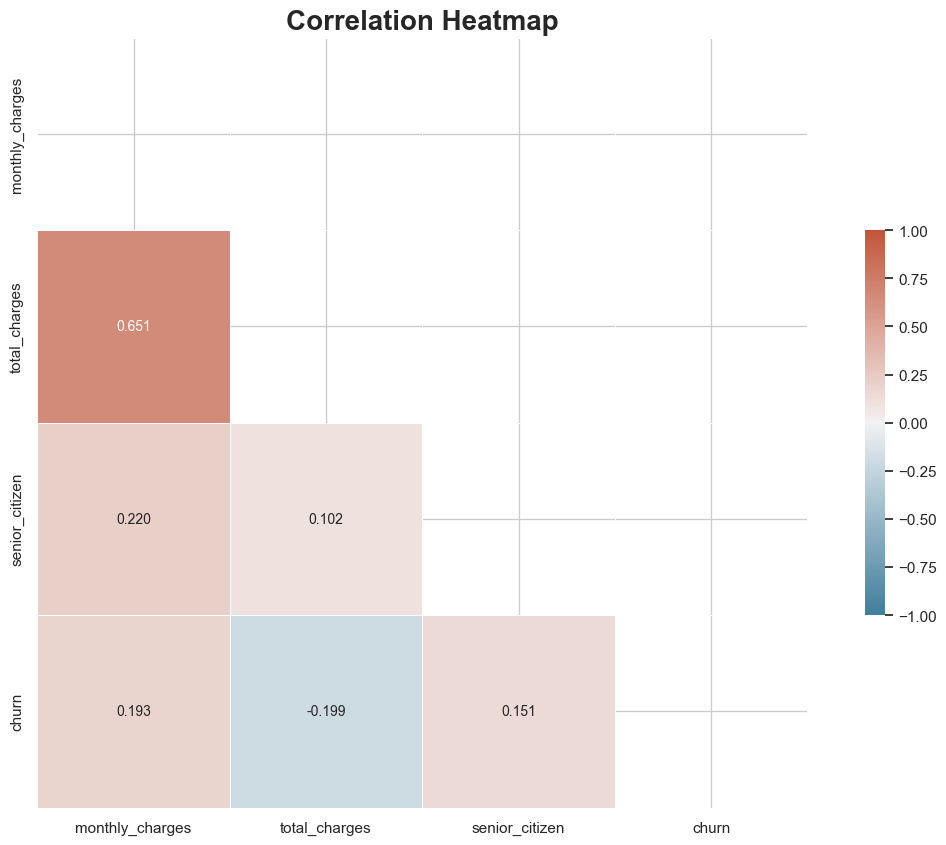

In [35]:
# Calcular la matriz de correlación
corr = df[['monthly_charges', 'total_charges', 'senior_citizen', 'churn']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(15, 10))

# Generar un mapa de colores divergente personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True, fmt=".3f", annot_kws={'size': 10},
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Añadir un título al mapa de calor
plt.title('Correlation Heatmap', fontsize=20, fontweight='bold')

# Mostrar el mapa de calor
plt.show()

Tras analizar nuestra matriz de correlación y nuestro gráfico de pare, podemos extraer las siguientes conclusiones:

- Existe una fuerte correlación entre la carga mensual y la carga total. Esto era esperado: a mayor carga mensual, se acumula una mayor carga total.
- Se identifica una correlación positiva moderada entre la carga mensual y los clientes de edad avanzada, lo que sugiere que los clientes seniors tienden a tener cargos mensuales más elevados en el servicio.
- Se muestra una correlación positiva leve entre los contratos con cargos mensuales y la tasa de cancelación del servicio. En otras palabras, los clientes que tienen contratos con cargos mensuales son ligeramente más propensos a cancelar el servicio.
- Existe una correlación negativa leve entre la carga total y la tasa de cancelación del servicio (churn). Esto indica que los clientes con una carga total más alta son menos propensos a cancelar el servicio.
- Finalmente, hay una correlación positiva entre la tasa de cancelación del servicio y los clientes seniors, lo que sugiere que los clientes de edad avanzada son más propensos a abandonar el servicio.

## Creación de Modelos

Previo a la creación de modelos, estableceremos nuestro dataset final escogiendo solo las columnas que creamos necesarias para los mdodelos. Posteriormente, para cada modelo dividiremos nuestro dataset en un conjunto de entramiento y prueba seguinedo la proporción 75:25 respectivamente.

In [36]:
df

customer_id  begin_date             end_date            type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     paperless_billing             payment_method  monthly_charges  \
0                  Yes           Electronic check            29.85   
1                   No               Mailed check            56.95   
2                  Yes               Mailed check            53.85   
3                   No  Bank transfer (automatic)            42.30   
4                  Yes           Electronic check            70.70   
...                ...                        ...              ...   
7038               Yes               Mailed check            84.80   
7039               Yes    Credit card (automatic)           103.20   
7040               Yes           Electronic check            29.60   
7041               Yes               Mailed check            74.40   
7042               Yes  Bank transfer (automatic)           105.65   

      total_charges  multiple_lines internet_service  ... online_backup  \
0             29.85  non-contracted              DSL  ...           Yes   
1           1889.50              No              DSL  ...            No   
2            108.15              No              DSL  ...           Yes   
3           1840.75  non-contracted              DSL  ...            No   
4            151.65              No      Fiber optic  ...            No   
...             ...             ...              ...  ...           ...   
7038        1990.50             Yes              DSL  ...            No   
7039        7362.90             Yes      Fiber optic  ...           Yes   
7040         346.45  non-contracted              DSL  ...            No   
7041         306.60             Yes      Fiber optic  ...            No   
7042        6844.50              No      Fiber optic  ...            No   

     device_protection tech_support streaming_tv streaming_movies  gender  \
0                   No           No           No               No  Female   
1                  Yes           No           No               No    Male   
2                   No           No           No               No    Male   
3                  Yes          Yes           No               No    Male   
4                   No           No           No               No  Female   
...                ...          ...          ...              ...     ...   
7038               Yes          Yes          Yes              Yes    Male   
7039               Yes           No          Yes              Yes  Female   
7040                No           No           No               No  Female   
7041                No           No           No               No    Male   
7042               Yes          Yes          Yes              Yes    Male   

     senior_citizen  partner dependents churn  
0                 0      Yes         No     0  
1                 0       No         No     0  
2                 0       No         No     1  
3                 0       No         No     0  
4                 0       No         No     1  
...             ...      ...        ...   ...  
7038              0      Yes        Yes     0  
7039              0      Yes        Yes     0  
7040              0      Yes        Yes     0  
7041              1      Yes 

In [37]:
# Crear dataset final
df_final = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)


In [38]:
# Muestra de dataset final
df_final.head()

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  total_charges  multiple_lines internet_service  \
0            29.85          29.85  non-contracted              DSL   
1            56.95        1889.50              No              DSL   
2            53.85         108.15              No              DSL   
3            42.30        1840.75  non-contracted              DSL   
4            70.70         151.65              No      Fiber optic   

  online_security online_backup device_protection tech_support streaming_tv  \
0              No           Yes                No           No           No   
1             Yes            No               Yes           No           No   
2             Yes           Yes                No           No           No   
3             Yes            No               Yes          Yes           No   
4              No            No                No           No           No   

  streaming_movies  gender  senior_citizen partner dependents  churn  
0               No  Female               0     Yes         No      0  
1               No    Male               0      No         No      0  
2               No    Male               0      No         No      1  
3               No    Male               0      No         No      0  
4               No  Female               0      No         No      1

### Regresión Lineal

Para la regresión lineal, usaaremos la codificación **OHE** para nuestras varaibles categóricas y estandarizaremos las numéricas.

In [39]:
# Codificar las características categóricas
df_ohe = pd.get_dummies(df_final, drop_first=True)

#Escalar los datos numéricos
scaler = StandardScaler()
scaler.fit(df_ohe[numeric_columns])
df_ohe[numeric_columns] = scaler.transform(df_ohe[numeric_columns])
df_ohe.head()

monthly_charges  total_charges  senior_citizen  churn  type_One year  \
0        -1.161694      -0.994194               0      0          False   
1        -0.260878      -0.173740               0      0           True   
2        -0.363923      -0.959649               0      1          False   
3        -0.747850      -0.195248               0      0           True   
4         0.196178      -0.940457               0      1          False   

   type_Two year  paperless_billing_Yes  \
0          False                   True   
1          False                  False   
2          False                   True   
3          False                  False   
4          False                   True   

   payment_method_Credit card (automatic)  payment_method_Electronic check  \
0                                   False                             True   
1                                   False                            False   
2                                   False                            False   
3                                   False                            False   
4                                   False                             True   

   payment_method_Mailed check  ...  device_protection_non-contracted  \
0                        False  ...                             False   
1                         True  ...                             False   
2                         True  ...                             False   
3                        False  ...                             False   
4                        False  ...                             False   

   tech_support_Yes  tech_support_non-contracted  streaming_tv_Yes  \
0             False                        False             False   
1             False                        False             False   
2             False                        False             False   
3              True                        False             False   
4             False                        False             False   

   streaming_tv_non-contracted  streaming_movies_Yes  \
0                        False                 False   
1                        False                 False   
2                        False                 False   
3                        False                 False   
4                        False                 False   

   streaming_movies_non-contracted  gender_Male  partner_Yes  dependents_Yes  
0                            False        False         True           False  
1                            False         True        False           False  
2                            False         True        False           False  
3                            False         True        False           False  
4                            False        False        False           False  

[5 rows x 29 columns]

In [40]:
# Determinar features y target del modelo
features_ohe = df_ohe.drop('churn', axis=1)
target_ohe = df_ohe['churn']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, 
    target_ohe,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento OHE: {features_train_ohe.shape}, {target_train_ohe.shape}')
print(f'Tamaño del conjunto de prueba OHE: {features_test_ohe.shape}, {target_test_ohe.shape}')

Tamaño del conjunto de entrenamiento OHE: (5274, 28), (5274,)
Tamaño del conjunto de prueba OHE: (1758, 28), (1758,)


In [41]:
# Entrenar el modelo de regresión lineal
start_train = time.time()
ds_model = DecisionTreeClassifier()
ds_model.fit(features_train_ohe, target_train_ohe)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred = ds_model.predict(features_test_ohe)
end_test = time.time()

# Calcular precisión
accuracy_ds = accuracy_score(target_test_ohe, target_pred)

print(f'Precisión del modelo de Árbol de Decisión (AUC-ROC): {accuracy_ds:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Precisión del modelo de Árbol de Decisión (AUC-ROC): 0.733
Tiempo de entrenamiento del modelo: 0.044s
Tiempo de prueba del modelo: 0.003s


### Arbol de Decisión

In [42]:
# Crear un copia de nuestro datset final
df_ordinal = df_final.copy().reset_index(drop=True)

# Codificar las características categóricas
encoder = OrdinalEncoder()
encoder.fit(df_ordinal[categorical_columns])
df_ordinal[categorical_columns] = pd.DataFrame(encoder.transform(df_ordinal[categorical_columns]), columns=categorical_columns)
df_ordinal.head()

type  paperless_billing  payment_method  monthly_charges  total_charges  \
0      0.0                1.0             2.0            29.85          29.85   
1      1.0                0.0             3.0            56.95        1889.50   
2      0.0                1.0             3.0            53.85         108.15   
3      1.0                0.0             0.0            42.30        1840.75   
4      0.0                1.0             2.0            70.70         151.65   
...    ...                ...             ...              ...            ...   
7027   1.0                1.0             3.0            84.80        1990.50   
7028   1.0                1.0             1.0           103.20        7362.90   
7029   0.0                1.0             2.0            29.60         346.45   
7030   0.0                1.0             3.0            74.40         306.60   
7031   2.0                1.0             0.0           105.65        6844.50   

      multiple_lines  internet_service  online_security  online_backup  \
0                2.0               0.0              0.0            1.0   
1                0.0               0.0              1.0            0.0   
2                0.0               0.0              1.0            1.0   
3                2.0               0.0              1.0            0.0   
4                0.0               1.0              0.0            0.0   
...              ...               ...              ...            ...   
7027             1.0               0.0              1.0            0.0   
7028             1.0               1.0              0.0            1.0   
7029             2.0               0.0              1.0            0.0   
7030             1.0               1.0              0.0            0.0   
7031             0.0               1.0              1.0            0.0   

      device_protection  tech_support  streaming_tv  streaming_movies  gender  \
0                   0.0           0.0           0.0               0.0     0.0   
1                   1.0           0.0           0.0               0.0     1.0   
2                   0.0           0.0           0.0               0.0     1.0   
3                   1.0           1.0           0.0               0.0     1.0   
4                   0.0           0.0           0.0               0.0     0.0   
...                 ...           ...           ...               ...     ...   
7027                1.0           1.0           1.0               1.0     1.0   
7028                1.0           0.0           1.0               1.0     0.0   
7029                0.0           0.0           0.0               0.0     0.0   
7030                0.0           0.0           0.0               0.0     1.0   
7031                1.0           1.0           1.0               1.0     1.0   

      senior_citizen  partner  dependents  churn  
0                0.0      1.0         0.0    0.0  
1                0.0      0.0         0.0    0.0  
2                0.0      0.0         0.0    1.0  
3                0.0      0.0         0.0    0.0  
4                0.0      0.0         0.0    1.0  
...              ...      ...         ...    ...  
7027             0.0      1.0         1.0    0.0  
7028             0.0      1.0         1.0    0.0  
7029             0.0      1.0         1.0    0.0  
7030             1.0      1.0         0.0    1.0  
7031             0.0      0.0         0.0    0.0  

[7032 rows x 18 columns]

In [43]:
# Determinar features y target del modelo
features_ordinal = df_ordinal.drop('churn', axis=1)
target_ordinal = df_ordinal['churn']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_ordinal, features_test_ordinal, target_train_ordinal, target_test_ordinal = train_test_split(
    features_ordinal, 
    target_ordinal,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento ordinal: {features_train_ordinal.shape}, {target_train_ordinal.shape}')
print(f'Tamaño del conjunto de prueba ordinal: {features_test_ordinal.shape}, {target_test_ordinal.shape}')

Tamaño del conjunto de entrenamiento ordinal: (5274, 17), (5274,)
Tamaño del conjunto de prueba ordinal: (1758, 17), (1758,)


**Ajuste de Hiperparámetros**

In [78]:
# Establecer los hiperparámetros de árbol de decisión
from sklearn.model_selection import GridSearchCV
params_dt = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params_dt,
    scoring='roc_auc',
    cv=3
)

In [79]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_dt.fit(features_train_ordinal, target_train_ordinal)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de Árbol de Decisión: {end - start:.3f}s')

Tiempo de ajuste de hiperparámetros de Árbol de Decisión: 39.764s


In [80]:
# Encontrar los mejores hiperparámetros
best_params = gridSearch_dt.best_params_

# best_set_of_params = gridSearch_dr.cv_results_['params'][best_index]
# best_score = gridSearch_dt.cv_results_['mean_test_score'][best_index]

print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 2}


In [81]:
# Entrenar el modelo de árbol de decisión
start_train = time.time()
dt_model = DecisionTreeClassifier(**best_params, random_state=12345)
dt_model.fit(features_train_ordinal, target_train_ordinal)
end_train= time.time()

# Realizamos predicciones
start_test = time.time()
target_pred_dt = dt_model.predict(features_test_ordinal)
end_test = time.time()


# Calcular precisión
accuracy_ds = accuracy_score(target_test_ordinal, target_pred_dt)

print(f'Precisión del modelo de Árbol de Decisión (AUC-ROC): {accuracy_ds:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Precisión del modelo de Árbol de Decisión (AUC-ROC): 0.790
Tiempo de entrenamiento del modelo: 0.016s
Tiempo de prueba del modelo: 0.002s


### Bosque Aleatorio

**Ajuste de Hiperparámetros**

In [82]:
params_rf = {
    'n_estimators': [10, 20, 40, 60, 80, 100],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params_rf,
    scoring='roc_auc',
    cv=3
)

In [83]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_rf.fit(features_train_ordinal, target_train_ordinal)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de Bosque Aleatorio: {end - start:.3f}s')

Tiempo de ajuste de hiperparámetros de Bosque Aleatorio: 85.285s


In [75]:
# Encontrar los mejores hiperparámetros
best_params = gridSearch_rf.best_params_

print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'max_depth': 6, 'n_estimators': 100}


In [85]:
# Entrenar el modelo de bosque aleatorio
start_train = time.time()
rf_model = RandomForestClassifier(max_depth=10, n_estimators=40, random_state=12345)
rf_model.fit(features_train_ordinal, target_train_ordinal)
end_train= time.time()

# Realizamos predicciones
start_test = time.time()
target_pred_rf = rf_model.predict(features_test_ordinal)
end_test = time.time()

# Calcular precisión
accuracy_rf = accuracy_score(target_test_ordinal, target_pred_rf)

print(f'Precisión del modelo de Bosque Aleatorio (AUC-ROC): {accuracy_rf:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Precisión del modelo de Bosque Aleatorio (AUC-ROC): 0.803
Tiempo de entrenamiento del modelo: 0.267s
Tiempo de prueba del modelo: 0.010s


### CatBoost

CatBoost es un métodode potenciación de gradiente que no necesita de un preprocesamiento de catracterícticas categóricas, por lo que no es necesario utilizar OHE o codificación de etiquetas ya que el propio método asigna etiquetas. Es por ello que trabajaremos con nuestro dataset final `df_final`.

In [95]:
# Determinar features y target del modelo
features = df_final.drop('churn', axis=1)
target = df_final['churn']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento ordinal: {features_train.shape}, {target_train.shape}')
print(f'Tamaño del conjunto de prueba ordinal: {features_test.shape}, {target_test.shape}')

Tamaño del conjunto de entrenamiento ordinal: (5274, 17), (5274,)
Tamaño del conjunto de prueba ordinal: (1758, 17), (1758,)


**Ajuste de Hiperparámetros**

In [116]:
# Establecer las características categóricas
cat_features = ['type', 'paperless_billing', 'payment_method', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection','tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents']

params_cb = {
    'depth': [4, 6, 10],
    'learning_rate': [0.1, 0.2, 0.5]
}

# Llamar al estimador que utilizaremos, CatBoostRegressor y lo pasamos a GridSearchCv
catboost_est = CatBoostClassifier(iterations=50, cat_features=cat_features, verbose=False, loss_function='Logloss')

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_cb = GridSearchCV(
    estimator=catboost_est,
    param_grid=params_cb,
    scoring='roc_auc',
    cv=3
)

In [117]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_cb.fit(features_train, target_train)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de Bosque Aleatorio: {end - start:.3f}s')

Tiempo de ajuste de hiperparámetros de Bosque Aleatorio: 67.294s


In [118]:
# Encontrar los mejores hiperparámetros
best_params = gridSearch_cb.best_params_

print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'depth': 6, 'learning_rate': 0.2}


In [119]:
# Entrenar el modelo de CatBoost
catboost_model = CatBoostClassifier(**best_params, iterations=100, loss_function='Logloss',  random_state=12345)

start_train = time.time()
catboost_model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_cat = catboost_model.predict(features_test)
end_test = time.time()

# Calcular precisión
accuracy_cat = accuracy_score(target_test, target_pred_cat)

print(f'Precisión del modelo de CatBoost (AUC-ROC): {accuracy_cat:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Precisión del modelo de CatBoost (AUC-ROC): 0.807
Tiempo de entrenamiento del modelo: 4.565s
Tiempo de prueba del modelo: 0.010s


### LightGBM

In [121]:
# Transformar caraterísticas categóricas a tipo "category"
for feature in cat_features:
    df_final[feature] = df_final[feature].astype("category")
    
# Determinar features y target del modelo
features_gbm = df_final.drop('churn', axis=1)
target_gbm = df_final['churn']

# Dividir nuestro dataset en conjunto de entrenamiento y prueba 75:25
features_train_gbm, features_test_gbm, target_train_gbm, target_test_gbm = train_test_split(
    features_gbm, 
    target_gbm,
    test_size=0.25,
    random_state=12345
)

# Comprobar división
print(f'Tamaño del conjunto de entrenamiento: {features_train_gbm.shape}, {target_train_gbm.shape}')
print(f'Tamaño del conjunto de prueba: {features_test_gbm.shape}, {target_test_gbm.shape}')

Tamaño del conjunto de entrenamiento: (5274, 17), (5274,)
Tamaño del conjunto de prueba: (1758, 17), (1758,)


In [122]:
# Establecer los hiperparámetros que vamos a ajustar
params_lightgbm = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.2, 0.5],
    'num_leaves': [10, 20]
}

# Llamar al estimador que utilizaremos
lightgbm_est = LGBMClassifier()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_lightgbm = GridSearchCV(
    estimator=lightgbm_est,
    param_grid=params_lightgbm,
    scoring='roc_auc',
    cv=3
)

In [123]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_lightgbm.fit(features_train_gbm, target_train_gbm)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de LightGBM: {end - start:.3f}s')

[LightGBM] [Info] Number of positive: 936, number of negative: 2580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 3516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266212 -> initscore=-1.013929
[LightGBM] [Info] Start training from score -1.013929
[LightGBM] [Info] Number of positive: 936, number of negative: 2580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 3516, number of used features: 17
[LightGBM] [Info] [binary:Bo

In [124]:
# Encontrar los mejores hiperparámetros
best_params = gridSearch_lightgbm.best_params_

print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10}


In [125]:
# Entrenar el modelo de LightGBM
lightgbm_model = LGBMClassifier(
    **best_params,
    random_seed=12345
)

start_train = time.time()
lightgbm_model.fit(features_train_gbm, target_train_gbm)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_gbm = lightgbm_model.predict(features_test_gbm)
end_test = time.time()

# Calcular precisión
accuracy_lgm = accuracy_score(target_test_gbm, target_pred_gbm)

print(f'Precisión del modelo de LighGBM (AUC-ROC): {accuracy_lgm:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

[LightGBM] [Info] Number of positive: 1404, number of negative: 3870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266212 -> initscore=-1.013929
[LightGBM] [Info] Start training from score -1.013929
Precisión del modelo de LighGBM (AUC-ROC): 0.810
Tiempo de entrenamiento del modelo: 0.050s
Tiempo de prueba del modelo: 0.010s


### XGBoost

In [127]:
# Establecer los hiperparámetros que vamos a ajustar
params_xboost = {
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100]
}

# Llamar al estimador que utilizaremos
xboost_est = XGBClassifier()

# Usar la función GridSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
gridSearch_xboost = GridSearchCV(
    estimator=xboost_est,
    param_grid=params_xboost,
    scoring='roc_auc',
    cv=3
)

In [128]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_xboost.fit(features_train_ohe, target_train_ohe)
end = time.time()
print(f'Tiempo de ajuste de hiperparámetros de XGBoost: {end - start:.3f}s')

Tiempo de ajuste de hiperparámetros de XGBoost: 2.573s


In [130]:
# Encontrar los mejores hiperparámetros
best_params = gridSearch_xboost.best_params_

print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'max_depth': 4, 'n_estimators': 50}


In [133]:
# Entrenar el modelo de XGBoost
xboost_model = XGBClassifier(
    **best_params,
    random_state=12345
)

start_train = time.time()
xboost_model.fit(features_train_ohe, target_train_ohe)
end_train= time.time()

# Realizar predicciones
start_test = time.time()
target_pred_xboost = xboost_model.predict(features_test_ohe)
end_test = time.time()

# Calcular precisión
accuracy_xboost= accuracy_score(target_test_ohe, target_pred_xboost)

print(f'Precisión del modelo de XGBoost (AUC-ROC): {accuracy_xboost:.3f}')
print(f'Tiempo de entrenamiento del modelo: {end_train - start_train:.3f}s')
print(f'Tiempo de prueba del modelo: {end_test - start_test:.3f}s')

Precisión del modelo de XGBoost (AUC-ROC): 0.804
Tiempo de entrenamiento del modelo: 0.046s
Tiempo de prueba del modelo: 0.007s


## Preguntas

1. ¿A qué se refiere la columnas PaperlessBilling en el dataset contract? Algunos casos de mailcheck cuentan con valor "YES" y "NO". ¿Qué significan estos casos?, ¿Son errores?.
2. ¿Los contratos son por producto o servicio total?, algunos clientes tienen ambos productos, pero solo un contrato.
3. En el caso del producto de internet, esta se puede configurar a través de una línea telefónica. ¿Esta línea puede ser de otro proveedor?
4. ¿El tipo de configuración de internet tiene algún efecto en la calidad del mismo? Por ejemplo: fibra óptica.
5. Actualmente, utilizar un medio de pago físico (papel) puede generar un cobro adicional ¿Ocurre en este caso?
6. ¿Hay algún beneifico entre eligir un plan de largo plazo en vez de uno de corto plazo?

## Plan de trabajo

1. Incialización
Describiremos el proyecto, establceremos los objetivos del mismo y haremos un pequeño resumen del contenido de nuestros datasets.
2. Cargar de datos
3. Análisis exploratorio
Realizaremos un análisis de nuestra data, veremos tanto si nuestros datos cuantan con valores atípicos, ausentes, duplicados o algún otro problema que creamos que debamos investigar más a fondo.
4. Análisis de datos
Haremos un análisis profundo de nuestras variables donde veremos la distribución de las mismas, relación entre ellas y otros aspectos necesarios para determinar el comportamiento de las mismas y, con ello, ver si es necesario hacer una modificación en alguna de ellas más adelante.
5. Preparación de datos
Prepararemos nuestros datos según las conclusiones de nuestro análisis previo. El objetivo de esta etapa es obtener nuestro dataset listo para poder utilizarlo en nuestros modelos, esto incluye tratamiento de ausentes y valores atpipicos, creación de nuevas variables, modificación de tipos de datos, adición de nuevas variables, entre otros relacionados.
6. Creación y evaluación de modelos
Crearemos distintos modelos, identificaremos los mejores hiperparámetros para cada uno, los entrenaremos con nuestro dataset y los evaluaremos. Estableceremos los resultados e identificaremos el mejor modelo.
7. Conclusión
Finalmente, haremos un resumen de los pasos realizados en el proyecto, insghts importantes encontrados y la conclusión acerca de nuestros modelos.